In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
import copy
import connectivity as cn

In [2]:
Pinksy_rinzel_eqs = '''    
dVs/dt=(-gLs*(Vs-VL)-gNa*(Minfs**2)*hs*(Vs-VNa)-gKdr*ns*(Vs-VK)+(gc/pp)*(Vd-Vs)+(Ip0-Iinssyn)/pp)/Cm : volt
dVd/dt=(-gLd*(Vd-VL)-ICad-gKahp*qd*(Vd-VK)-gKC*cd*chid*(Vd-VK)+(gc*(Vs-Vd))/(1.0-pp)-Isyn/(1.0-pp)+Id/(1.0-pp))/Cm : volt
dCad/dt=  -0.13*ICad/uamp/ms*scaler-0.075*Cad/ms : 1
dhs/dt=  alphahs-(alphahs+betahs)*hs : 1
dns/dt=  alphans-(alphans+betans)*ns : 1
dsd/dt=  alphasd-(alphasd+betasd)*sd : 1
dcd/dt=  alphacd-(alphacd+betacd)*cd : 1
dqd/dt=  alphaqd-(alphaqd+betaqd)*qd : 1
ICad=     gCa*sd*sd*(Vd-VCa) : amp
alphams=  0.32*(-46.9-Vs/mV)/(exp((-46.9-Vs/mV)/4.0)-1.000001)/ms : Hz
betams=   0.28*(Vs/mV+19.9)/(exp((Vs/mV+19.9)/5.0)-1.000001)/ms : Hz
Minfs=    alphams/(alphams+betams) : 1
alphans=  0.016*(-24.9-Vs/mV)/(exp((-24.9-Vs/mV)/5.0)-1.000001)/ms : Hz
betans=   0.25*exp(-1.0-0.025*Vs/mV)/ms : Hz
alphahs=  0.128*exp((-43.0-Vs/mV)/18.0)/ms : Hz
betahs=   4.0/(1.00001+exp((-20.0-Vs/mV)/5.0))/ms : Hz
alphasd=  1.6/(1.0001+exp(-0.072*(Vd/mV-5.0)))/ms : Hz
betasd=   0.02*(Vd/mV+8.9)/(exp((Vd/mV+8.9)/5.0)-1.0)/ms : Hz
alphacd=((Vd/mV<=-10)*exp((Vd/mV+50.0)/11-(Vd/mV+53.5)/27)/18.975+(Vd/mV>-10)*2.0*exp((-53.5-Vd/mV)/27.0))/ms  : Hz
betacd=   ((Vd/mV<=-10)*(2.0*exp((-53.5-Vd/mV)/27.0)-alphacd*ms)+(Vd/mV>-10)*0)/ms : Hz
alphaqd=  clip(0.00002*Cad,0,0.01)/ms : Hz
betaqd=   0.001/ms : Hz
chid=     clip(Cad/250.0,0,1.0) : 1
INMDA=gNMDA*Si*(1+0.28*exp(-0.062*(Vs/mV)))**(-1)*(Vd-Vsyn) : amp
Hxs=0<=((Vs/mV+50)*1) : 1
Hxw=0<=((Vs/mV+40)*1) : 1
dSi/dt=(Hxs-Si/150)/second : 1
Isyn=Issyn+INMDA : amp
Issyn=gbarsyn*clip(ssyn,0,7000)*(Vd-Vsyn): amp
Id: amp
dssyn/dt=-ssyn/tausyn: 1
dinssyn/dt=-inssyn/tauisyn: 1
Iinssyn=gbarsyn*clip(inssyn,0,7000)*(Vs-VK): amp
counter:1
'''

In [3]:
buzsaki_eqs = '''
dv/dt = (-gNai*m**3*h*(v-VNai)-gKi*n**4*(v-VKi)-gL*(v-VL2)-Issyn-Iinssyn-Iapp2)/Cmi : volt
m = alpha_m/(alpha_m+beta_m) : 1
alpha_m = -0.1/mV*(v+35*mV)/(exp(-0.1/mV*(v+35*mV))-1)/ms : Hz
beta_m = 4*exp(-(v+60*mV)/(18*mV))/ms : Hz
dh/dt = 5*(alpha_h*(1-h)-beta_h*h) : 1
alpha_h = 0.07*exp(-(v+58*mV)/(20*mV))/ms : Hz
beta_h = 1./(exp(-0.1/mV*(v+28*mV))+1)/ms : Hz
dn/dt = 5*(alpha_n*(1-n)-beta_n*n) : 1
alpha_n = -0.01/mV*(v+34*mV)/(exp(-0.1/mV*(v+34*mV))-1)/ms : Hz
beta_n = 0.125*exp(-(v+44*mV)/(80*mV))/ms : Hz
Issyn=gbarsyn*(clip(ssyn,0,7000))*(v-Vsyn): amp
dssyn/dt=-ssyn/tausyn: 1
dinssyn/dt=-inssyn/taguisyn: 1
Iinssyn=gbarsyn*clip(inssyn,0,7000)*(v-VK):amp
'''

In [4]:
# Pyr Cell Default Params
defaultclock.dt = 0.05*ms
speed=500*um/ms
Isyn=0*uamp
areapyr=50000*um**2
test=areapyr
Ip0=-0.3*nA
gLs=0.1  *msiemens*cm**-2*test
gLd=0.1  *msiemens*cm**-2*test
gNa=30  *msiemens*cm**-2*test
gKdr=15  *msiemens*cm**-2*test
gCa=7  *msiemens*cm**-2*test #CA1 Calcium Conductance
gKahp=0.8*msiemens*cm**-2*test  
gKC=15  *msiemens*cm**-2*test
VNa=60*mV
VCa=80*mV
VK=-75*mV
VL=-60*mV
Vsyn=0*mV 
vtsyn=0*mV 
gc=1.75*usiemens
pp=0.5
Cm=3  *uF*cm**-2*test
gNMDA=0*msiemens*cm**-2*test
gampa=0*msiemens*cm**-2*test
gbarsyn=1*nS
tausyn= 2*ms
tauisyn=7*ms
scaler=(10**8*um**2/(test))

# IN Default Params
interneuron_size=20000*um**2
Cmi = 1*uF/cm**2*interneuron_size
gL = 0.1*msiemens/cm**2*interneuron_size
VL2 = -65*mV
VNai = 55*mV
VKi = -90*mV
gNai = 35*msiemens/cm**2*interneuron_size
gKi = 9*msiemens/cm**2*interneuron_size
Esyn=-75*mV
taguisyn=2*ms
Iapp2=0*nA

In [5]:
#Create CA1 pyramidal cell object
n_ca1_neurons=1000
CA1_pyramidal = NeuronGroup(n_ca1_neurons+1,
                            Pinksy_rinzel_eqs,threshold='Vs>-20*mV',
                            refractory='Vs>-60*mV',
                            method='euler')
CA1_pyramidal.Vs='(randn()*60*.05-60)*mV'
CA1_pyramidal.Vd='(randn()*65*.05-65)*mV'
CA1_pyramidal.hs=.999
CA1_pyramidal.ns=.0001
CA1_pyramidal.sd=.009
CA1_pyramidal.cd=.007
CA1_pyramidal.qd=.01
CA1_pyramidal.Cad=.20
CA1_pyramidal.Si=0
CA1_pyramidal.ssyn=0
CA1_pyramidal.inssyn=0
CA1_pyramidal.Id=0*nA

In [6]:
#Create CA1 IN object
Ca1_interneuron=NeuronGroup(np.round(n_ca1_neurons/10+1),
                            buzsaki_eqs,threshold='v>-20*mV',
                            refractory='v>-60*mV',
                            method='euler')
Ca1_interneuron.v='(randn()*60*.05-60)*mV'
Ca1_interneuron.h=.999
Ca1_interneuron.n=.0001
Ca1_interneuron.ssyn=0

In [7]:
#Create arrays specifiying PY-PY/PY-IN synaptic connectivity
ca1_pypy_kij=0
ca1_pypy_kij_sd=ca1_pypy_kij/20
ca1_pyin_kij=20
ca1_pyin_kij_sd=ca1_pyin_kij/20
connectivity2ex,connectivity2in,delayex,delayin=cn.excite_to_excite_wire_it_up(n_ca1_neurons,
                                                                            ca1_pypy_kij,
                                                                            ca1_pypy_kij_sd,
                                                                            ca1_pyin_kij,
                                                                            ca1_pyin_kij_sd,
                                                                            speed)

In [8]:
#Create arrays specifying IN-IN/IN-PY synaptic connectivity
ca1_inpykij=400
ca1_inpykij_sd=ca1_inpykij/20
ca1in2inkij=100
ca1in2iniij_sd=ca1in2inkij/20
connectivityin2ex,connectivityin2in,delayinex,delayinin=cn.ca1in_wire_it_up(1000,
                                                                         ca1_inpykij,
                                                                         ca1_inpykij_sd,
                                                                         ca1in2inkij,
                                                                         ca1in2iniij_sd,
                                                                         speed)

In [9]:
#Generate synaptic connections

#IN-IN synapses
Ca1_in_in=Synapses(Ca1_interneuron,Ca1_interneuron,on_pre='inssyn+=5')
Ca1_in_in.connect(i=list(connectivityin2in[0:,0]),j=list(connectivityin2in[0:,1]))
Ca1_in_in.delay=delayinin[0:]

#PY-IN synapses
Ca1_py_in=Synapses(CA1_pyramidal,Ca1_interneuron,on_pre='ssyn+=2.5')
Ca1_py_in.connect(i=list(connectivity2in[0:,0]),j=list(connectivity2in[0:,1]))
Ca1_py_in.delay=delayin[0:]

#PY-PY synapses
Ca1_in_py=Synapses(Ca1_interneuron,CA1_pyramidal,on_pre='inssyn+=15')
Ca1_in_py.connect(i=list(connectivityin2ex[0:,0]),j=list(connectivityin2ex[0:,1]))
Ca1_in_py.delay=delayinex[0:]

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [10]:
#Create CA3 pyramidal cell object
n_ca3_neurons=1000   
CA3_pyramidal = NeuronGroup(n_ca3_neurons+1,
                            Pinksy_rinzel_eqs,
                            threshold='Vs>-20*mV',
                            refractory='Vs>-60*mV',
                            method='euler')
CA3_pyramidal.Vs='(randn()*60*.05-60)*mV'
CA3_pyramidal.Vd='(randn()*65*.05-65)*mV'
CA3_pyramidal.hs=.999
CA3_pyramidal.ns=.0001
CA3_pyramidal.sd=.009
CA3_pyramidal.cd=.007
CA3_pyramidal.qd=.01
CA3_pyramidal.Cad=.20
CA3_pyramidal.Si=0
CA3_pyramidal.ssyn=0
CA3_pyramidal.inssyn=0
# CA3_pyramidal.Iapp=0*nA
CA3_pyramidal.counter=0
# CA3_pyramidal.Id = '(randn()*0.03+0.3)*nA'

In [11]:
#Create CA3 IN object
Ca3_interneuron=NeuronGroup(np.round(n_ca3_neurons/10+1),
                            buzsaki_eqs,threshold='v>-20*mV',
                            refractory='v>-60*mV',
                            method='euler')
Ca3_interneuron.v=-60*mV
Ca3_interneuron.h=.999
Ca3_interneuron.n=.0001
Ca3_interneuron.ssyn=0

In [12]:
#Generate array specifying CA3 connectivity schema
ca3_pypy_kij=55
ca3_pypy_kij_sd=ca3_pypy_kij/20
ca3_pyin_kij=5
ca3_pyin_kij_sd=ca3_pyin_kij/20
connectivity2ex,connectivity2in,delayex,delayin=cn.excite_to_excite_wire_it_up(n_ca3_neurons,
                                                                            ca3_pypy_kij,
                                                                            ca3_pypy_kij_sd,
                                                                            ca3_pyin_kij,
                                                                            ca3_pyin_kij_sd,
                                                                            speed)

In [13]:
#Generate array specifying CA3 IN connectivity schema
ca3_inpykij=68
ca3_inpykij_sd=ca3_inpykij/20
connectivityin2ex,delayinin=cn.in2ex_wire_it_up(n_ca3_neurons,ca3_inpykij,ca3_inpykij_sd,speed)

In [14]:
#Generate synaptic connections

#CA3 PY-PY connections
Ca3_py_py=Synapses(CA3_pyramidal,CA3_pyramidal,on_pre='ssyn+=15')
Ca3_py_py.connect(i=list(connectivity2ex[0:,0]),j=list(connectivity2ex[0:,1]))
Ca3_py_py.delay=delayex[0:]

#CA3 PY-IN connections
Ca3_py_in=Synapses(CA3_pyramidal,Ca3_interneuron,on_pre='ssyn+=3')    
Ca3_py_in.connect(i=list(connectivity2in[0:,0]),j=list(connectivity2in[0:,1]))
Ca3_py_in.delay=delayin[0:]

#CA3 IN-PY connections
Ca3_in_py=Synapses(Ca3_interneuron,CA3_pyramidal,on_pre='inssyn+=50')
Ca3_in_py.connect(i=list(connectivityin2ex[0:,0]),j=list(connectivityin2ex[0:,1]))

In [15]:
#Create array for schaffer-collateral synaptic connectivity (or load from memory)
exkijsc=130
exkijsdsc=exkijsc/20

from os import path
import pickle

#Loads pre-made schaffer-collateral connectivity schema (if exists) to save time
file_flag = True
if path.exists('SC_connect.pkl'):
    with open('SC_connect.pkl', 'rb') as f: 
        data = pickle.load(f)
        #Checks to see that saved file has same params as current
        if data[4] != n_ca1_neurons or data[5] != exkijsc or data[6] != exkijsdsc:
            file_flag = False
        else:
            scconnectivityex = data[0]
            scconnectivityin = data[1]
            scdelayex = data[2]
            scdelayin = data[3]
else:
    file_flag = False

#Creates connectivity schema if not available to load
if file_flag == False:
    scconnectivityex,scconnectivityin,scdelayex,scdelayin=cn.schafer_collaterals(n_ca1_neurons,
                                                                          exkijsc,exkijsdsc,
                                                                          0,0,
                                                                          speed)
    #Save connectivity arrays for future speed
    with open('SC_connect.pkl', 'wb') as f:  
        pickle.dump([scconnectivityex,scconnectivityin,scdelayex,scdelayin,n_ca1_neurons,exkijsc,exkijsdsc], f)

In [16]:
#Schaffer-Collateral Synapses
SC_py_py=Synapses(CA3_pyramidal,CA1_pyramidal,on_pre='ssyn+=1.5') #Original: 1.5
SC_py_py.connect(i=list(scconnectivityex[0:,0]),j=list(scconnectivityex[0:,1]))
SC_py_py.delay=scdelayex[0:]
SC_py_in=Synapses(CA3_pyramidal,Ca1_interneuron,on_pre='ssyn+=0.8') #Original: 0.8
SC_py_in.connect(i=list(scconnectivityin[0:,0]),j=list(scconnectivityin[0:,1]))
SC_py_in.delay=scdelayin[0:]

In [17]:
#    ---    Full Network Simulation    ---    

sim_length = 2000 #Simulation Length (ms)

#Continually injects current (0.3±0.03nA) into the dendrite of every CA3 pyr cell
CA3_pyramidal.run_regularly('Id=(randn()*0.03+0.3)*nA',
                           dt=1*ms)

#Spike Monitors
CA3_spikes = SpikeMonitor(CA3_pyramidal)
Ca3_IN_spikes = SpikeMonitor(Ca3_interneuron)
CA1_spikes = SpikeMonitor(CA1_pyramidal)
Ca1_IN_spikes = SpikeMonitor(Ca1_interneuron)

#State Monitors
CA3_state = StateMonitor(CA3_pyramidal, True ,record=True,dt=1*ms)
Ca3_IN_state = StateMonitor(Ca3_interneuron, True ,record=True,dt=1*ms)
CA1_state = StateMonitor(CA1_pyramidal, True ,record=True,dt=1*ms)
Ca1_IN_state = StateMonitor(Ca1_interneuron, True ,record=True,dt=1*ms)

run(sim_length*ms, report='text')

Starting simulation at t=0. s for a duration of 2. s
0.3229 s (16%) simulated in 10s, estimated 52s remaining.
0.65325 s (32%) simulated in 20s, estimated 41s remaining.
0.985 s (49%) simulated in 30s, estimated 31s remaining.
1.3169 s (65%) simulated in 40s, estimated 21s remaining.
1.65175 s (82%) simulated in 50s, estimated 11s remaining.
1.9781 s (98%) simulated in 1m 0s, estimated 1s remaining.
2. s (100%) simulated in 1m 0s


In [18]:
# #Save Key Data from Simulation
# CA1_TS = CA1_state.t/ms
# CA1_Spikes = CA1_spikes.t/ms
# CA1_SpikeIndex = np.array(CA1_spikes.i)
# CA1_Som_Current = np.array(CA1_state.Iinssyn)
# CA1_Den_Current = np.array(CA1_state.Issyn)

# #Saves all values to one pickle file
# with open('CA1_pyr_test.pkl', 'wb') as f:  
#     pickle.dump([CA1_TS,CA1_Spikes,CA1_SpikeIndex,CA1_Som_Current,CA1_Den_Current], f)

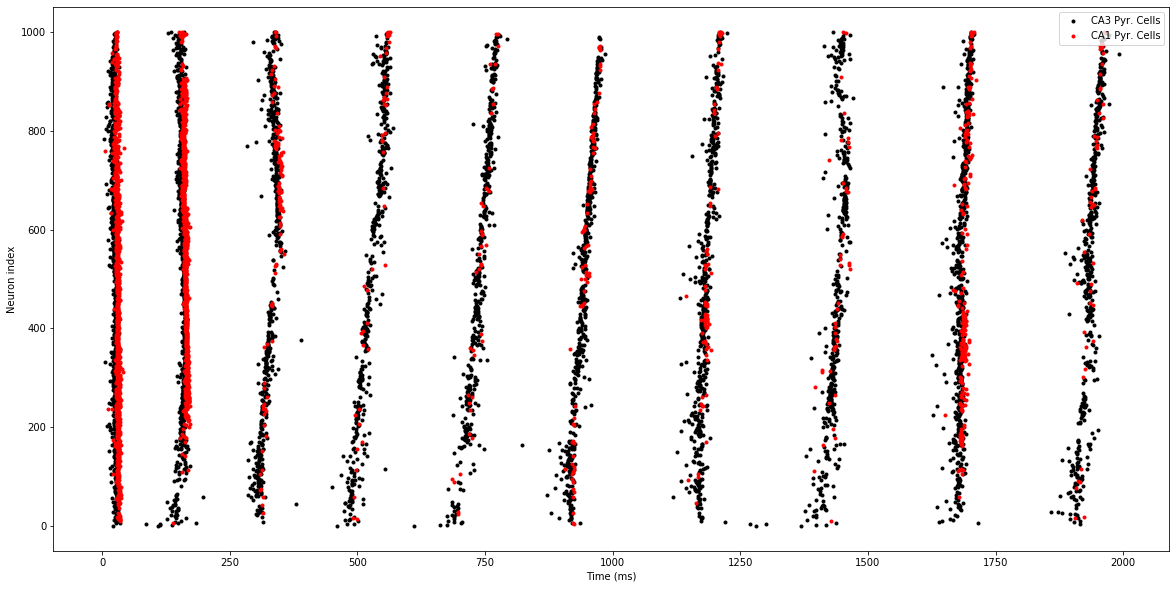

In [19]:
#Pyramidal Cell Raster
plt.figure(figsize=(20,10))
plt.plot(CA3_spikes.t/ms, CA3_spikes.i, '.k', label='CA3 Pyr. Cells')
plt.plot(CA1_spikes.t/ms, CA1_spikes.i, '.r', label='CA1 Pyr. Cells')
xlabel('Time (ms)')
ylabel('Neuron index')
plt.legend(loc="upper right")

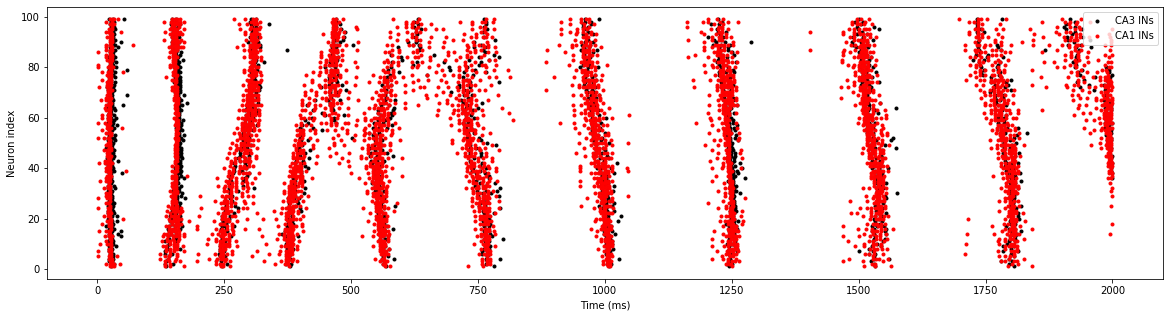

In [20]:
#IN Raster
plt.figure(figsize=(20,5))
plt.plot(Ca3_IN_spikes.t/ms, Ca3_IN_spikes.i, '.k', label='CA3 INs')
plt.plot(Ca1_IN_spikes.t/ms, Ca1_IN_spikes.i, '.r', label='CA1 INs')
xlabel('Time (ms)')
ylabel('Neuron index')
plt.legend(loc="upper right")

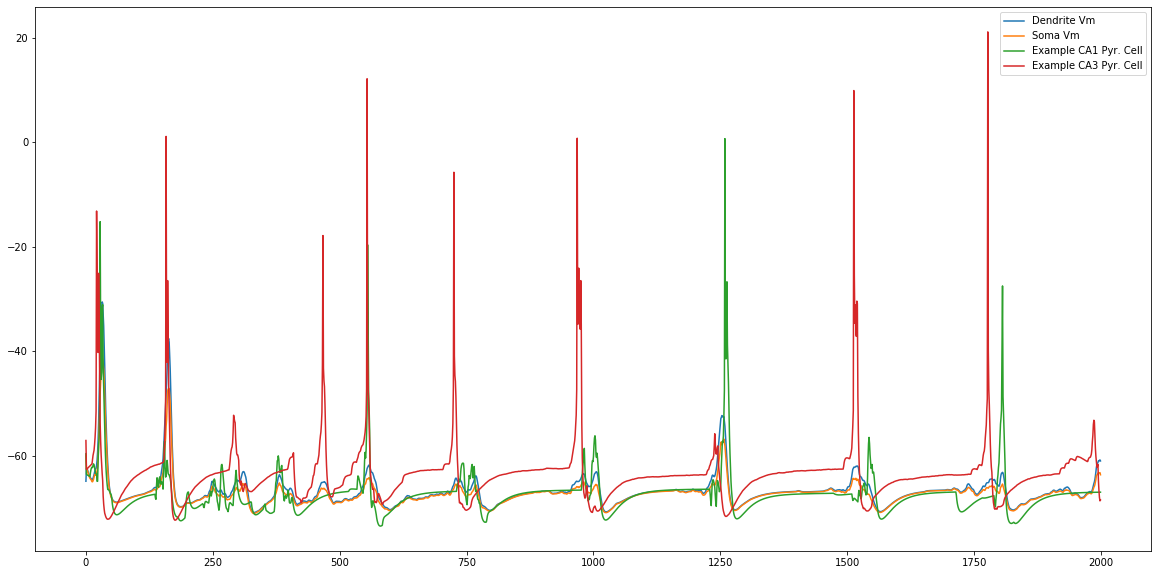

In [21]:
#Membrane Potential (ie LFP)
plt.figure(figsize=(20,10))
plt.plot(CA1_state.t/ms,np.average(CA1_state.Vd/mV,axis=0),label='Dendrite Vm')
plt.plot(CA1_state.t/ms,np.average(CA1_state.Vs/mV,axis=0),label='Soma Vm')
plt.plot(CA1_state.t/ms,CA1_state[201].Vs/mV,label='Example CA1 Pyr. Cell')
plt.plot(CA3_state.t/ms,CA3_state[601].Vs/mV,label='Example CA3 Pyr. Cell')
# plt.plot(Ca1_IN_state.t/ms,Ca1_IN_state[10].v/mV,label='Example CA1 IN')
# plt.plot(Ca3_IN_state.t/ms,Ca3_IN_state[10].v/mV,label='Example CA3 IN')
plt.legend(loc="upper right")

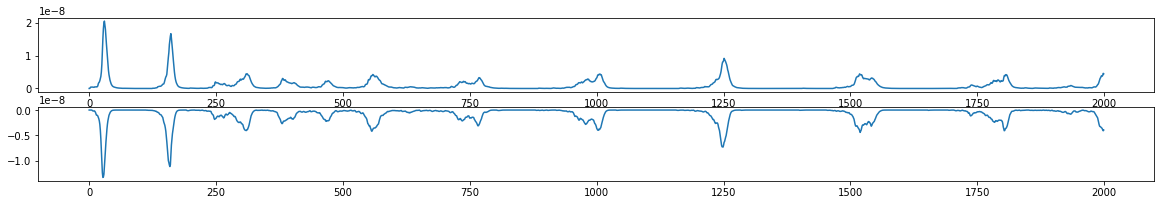

In [22]:
#Synaptic potentials
fig, axs = plt.subplots(2,figsize=(20,3))
# axs[0].plot(CA1_state.t/ms,np.average(CA1_state.inssyn-CA1_state.ssyn,axis=0))
axs[0].plot(CA1_state.t/ms,np.average(CA1_state.Iinssyn,axis=0))
axs[1].plot(CA1_state.t/ms,np.average(CA1_state.Issyn,axis=0))

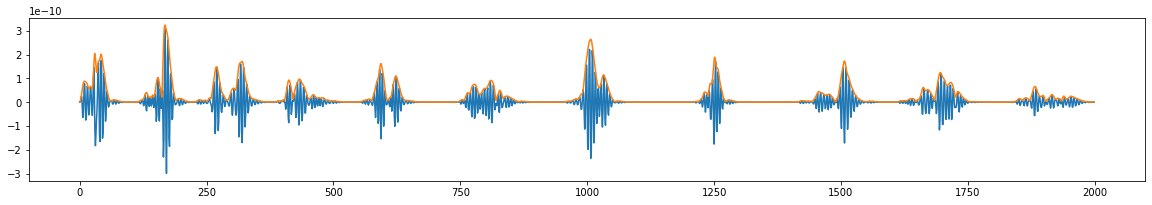

In [20]:
from scipy.signal import butter, lfilter, hilbert

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

data = np.average(CA1_state.Iinssyn,axis=0)
lc = 150.0 #Low cut of filter
hc = 200.0 #High cut of filter
fs = 1000.0 #Sampling frequency (currently set at 10000Hz)

#Filtered signal
filt_LFP = butter_bandpass_filter(data,lc,hc,fs,order=2)

#Amplitude envelope
analytic_signal = hilbert(filt_LFP)
amplitude_envelope = np.abs(analytic_signal)

plt.figure(figsize=(20,3))
plt.plot(CA1_state.t/ms,filt_LFP)
plt.plot(CA1_state.t/ms,amplitude_envelope)

In [24]:
#Run ripple detection to get ripple times
from ripple_detection import Kay_ripple_detector
time = np.array(CA1_state.t)
speed = np.zeros(np.shape(data))

LFP = np.expand_dims(filt_LFP, axis=1)

ripple_times = Kay_ripple_detector(time, LFP, speed, fs, zscore_threshold=1.5)

#Convert to numpy array
ripple_times = ripple_times.to_numpy()

In [25]:
ripple_times

array([[0.015, 0.06 ],
       [0.142, 0.188],
       [0.543, 0.592],
       [1.736, 1.829]])

In [26]:
#Spike participation in ripple events & ripple properties

#Gets time indices of every ripple
for iRip in range(0,len(ripple_times)):
    
    #Finds every time index falling within a ripple event
    inds = np.where((CA1_spikes.t/ms >= ripple_times[iRip,0]*1000) & 
                    (CA1_spikes.t/ms <= ripple_times[iRip,1]*1000))

    #Adds all time indices falling within a ripple window to one super array
    if iRip == 0:
        ripple_time_indices = inds[0]
    else:
        ripple_time_indices = np.concatenate((ripple_time_indices,inds[0]))

#Calculates number of ripple-associated spikes for each cell
CA1_spikes_per_ripple = np.zeros((n_ca1_neurons,1))
for iCell in range(0,n_ca1_neurons):
    cell_spikes = np.where(CA1_spikes.i == iCell)
    CA1_spikes_per_ripple[iCell] = len(np.intersect1d(cell_spikes, ripple_time_indices)) / len(ripple_times)    
        
np.savez('gCA6.475_Ripp_Spikes', CA1_spikes_per_ripple)

In [27]:
ripple_times

array([[0.015, 0.06 ],
       [0.142, 0.188],
       [0.543, 0.592],
       [1.736, 1.829]])

In [28]:
#Ripple Properties

rip_amp = np.zeros(len(ripple_times))
rip_length = np.zeros(len(ripple_times))
for iRip in range(0,len(ripple_times)):
    rip_ind = np.where((CA1_state.t/ms >= ripple_times[iRip,0]*1000) &
             (CA1_state.t/ms <= ripple_times[iRip,1]*1000))
    
    #Adds peak amplitude to amp array
    rip_amp[iRip] = np.max(amplitude_envelope[rip_ind[0][0]:rip_ind[0][-1]])
    
    #Adds ripple length to length array
    rip_length[iRip] = ripple_times[iRip,1]-ripple_times[iRip,0]
    

np.savez('gCA6.475_Ripp_Props', rip_amp, rip_length)